In [1]:
import tensorflow as tf
import pandas as pad
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(data_train, data_valid, data_test), dataset_info = tfds.load(
    'deep_weeds',
    split=['train[:60%]', 'train[60%:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised = True
)

2021-10-01 08:44:09.424968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 08:44:09.433530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 08:44:09.433982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 08:44:09.435728: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# 看一下, 一共有多少分类
num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Classes: 9


In [4]:
# 数数具体每个训练，验证，测试集都有多少数据
num_train = len(data_train)
num_valid = len(data_valid)
num_test = len(data_test)
print('Total Number of Training Images: {}'.format(num_train))
print('Total Number of Validation Images: {}'.format(num_valid))
print('Total Number of Test Images: {}'.format(num_test))

Total Number of Training Images: 10505
Total Number of Validation Images: 3502
Total Number of Test Images: 3502


In [5]:
IMAGE_RES = 224
def preprocess_with_label(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

def preprocess_without_label(dic):
    image = dic['image']
    preprocessed_image = tf.image.resize(image,[256,256])/255 # Scale to between 0 and 1
    label = dic['label']
    return preprocessed_image, label

In [6]:
# 制作成batch
BATCH_SIZE = 32


train_batches = data_train.shuffle(num_train//4).map(preprocess_with_label).batch(BATCH_SIZE).prefetch(1)
validation_batches = data_valid.map(preprocess_with_label).batch(BATCH_SIZE).prefetch(1)

"""train_batches = data_train.map(preprocess_without_label).batch(BATCH_SIZE)
validation_batches = data_valid.map(preprocess_without_label).batch(BATCH_SIZE)"""

print(train_batches)
print(validation_batches)
for i, example in enumerate(train_batches.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

2021-10-01 08:44:10.123892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>
Image 1 shape: (32, 224, 224, 3) label: [2 8 8 8 0 3 8 8 3 8 0 8 5 4 4 8 8 2 1 8 0 0 0 8 2 8 0 6 8 8 6 5]
Image 2 shape: (32, 224, 224, 3) label: [5 7 0 8 8 8 8 8 8 6 7 2 8 8 8 8 3 8 8 8 8 1 2 3 8 0 8 8 8 8 8 8]
Image 3 shape: (32, 224, 224, 3) label: [8 8 8 8 6 8 8 8 2 8 8 8 8 6 8 8 1 0 7 1 2 8 8 8 7 5 5 8 1 4 8 2]
Image 4 shape: (32, 224, 224, 3) label: [8 3 8 3 0 3 0 8 0 7 8 8 8 8 8 7 8 6 8 8 6 8 0 0 8 8 0 4 8 8 8 7]
Image 5 shape: (32, 224, 224, 3) label: [0 8 8 8 8 8 3 2 8 8 8 8 8 8 8 8 2 8 8 7 8 8 0 0 8 6 8 2 8 8 1 7]


In [7]:
import tensorflow_hub as hub
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
EPOCHS = 100
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/100


2021-10-01 08:44:16.398897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


329/329 [==============================] - 28s 72ms/step - loss: 0.9275 - accuracy: 0.6816 - val_loss: 0.7248 - val_accuracy: 0.7484
Epoch 2/100
329/329 [==============================] - 24s 70ms/step - loss: 0.6424 - accuracy: 0.7781 - val_loss: 0.6195 - val_accuracy: 0.7853
Epoch 3/100
329/329 [==============================] - 24s 69ms/step - loss: 0.5513 - accuracy: 0.8076 - val_loss: 0.5887 - val_accuracy: 0.7967
Epoch 4/100
329/329 [==============================] - 24s 69ms/step - loss: 0.5016 - accuracy: 0.8300 - val_loss: 0.5598 - val_accuracy: 0.8018
Epoch 5/100
329/329 [==============================] - 24s 70ms/step - loss: 0.4612 - accuracy: 0.8436 - val_loss: 0.5692 - val_accuracy: 0.7978
Epoch 6/100
329/329 [==============================] - 24s 69ms/step - loss: 0.4364 - accuracy: 0.8495 - val_loss: 0.5438 - val_accuracy: 0.8135
Epoch 7/100
329/329 [==============================] - 24s 69ms/step - loss: 0.4081 - accuracy: 0.8625 - val_loss: 0.5446 - val_accuracy: 0.80

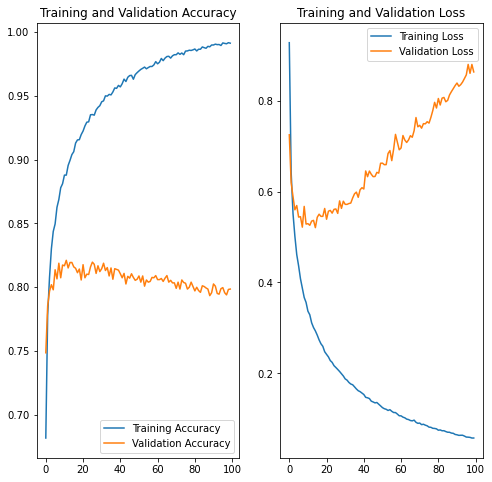

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()